In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import zipfile, os

zip_path = '/content/drive/MyDrive/cleaned_dataset2 (2).zip'
extract_path = '/content/cleaned_dataset2'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Extracted:", os.listdir(extract_path))


✅ Extracted: ['cleaned_dataset2']


In [ ]:
expected_folders = ['Train', 'Validate', 'Test']
contents = os.listdir(extract_path)
base_path = None

for folder in contents:
    candidate = os.path.join(extract_path, folder)
    if os.path.isdir(candidate):
        subfolders = os.listdir(candidate)
        if all(f in subfolders for f in expected_folders):
            base_path = candidate
            break

if base_path is None:
    raise Exception("❌ Could not locate Train/Validate/Test folders.")
print("✅ Base path set to:", base_path)


✅ Base path set to: /content/cleaned_dataset2/cleaned_dataset2


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    vertical_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_path, 'Train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_path, 'Validate'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_path, 'Test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))


Found 2131 images belonging to 8 classes.
Found 303 images belonging to 8 classes.
Found 616 images belonging to 8 classes.


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Fine-tune last 4 conv layers
for layer in base_model.layers[:-4]:
    layer.trainable = False
for layer in base_model.layers[-4:]:
    layer.trainable = True

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(train_generator.num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,113,800 (57.65 MB)

 Trainable params: 7,477,000 (28.52 MB)

 Non-trainable params: 7,636,800 (29.13 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/best_vgg16_model_improved.keras',
    monitor='val_accuracy',
    save_best_only=True
)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint, lr_scheduler]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 65s 714ms/step - accuracy: 0.2496 - loss: 2.4727 - val_accuracy: 0.3696 - val_loss: 1.7561 - learning_rate: 1.0000e-04
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 52s 475ms/step - accuracy: 0.4538 - loss: 1.8821 - val_accuracy: 0.4026 - val_loss: 1.5957 - learning_rate: 1.0000e-04
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 33s 490ms/step - accuracy: 0.5487 - loss: 1.5924 - val_accuracy: 0.4785 - val_loss: 1.4031 - learning_rate: 1.0000e-04
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 41s 485ms/step - accuracy: 0.5838 - loss: 1.4077 - val_accuracy: 0.6667 - val_loss: 1.1280 - learning_rate: 1.0000e-04
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 33s 486ms/step - accuracy: 0.6204 - loss: 1.2677 - val_accuracy: 0.5347 - val_loss: 1.4955 - learning_rate: 1.0000e-04
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 30s 452ms/step - accuracy: 0.6141 - loss: 1.2913 - val_accuracy: 0.6040 - val_loss: 1.1107 - learning_rate: 1.0000e-04
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 30s 453ms/step - acc

In [ ]:
loss, acc = model.evaluate(test_generator)
print(f"✅ Final Test Accuracy: {acc*100:.2f}%")


20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 385ms/step - accuracy: 0.6509 - loss: 1.0541
✅ Final Test Accuracy: 72.73%


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step


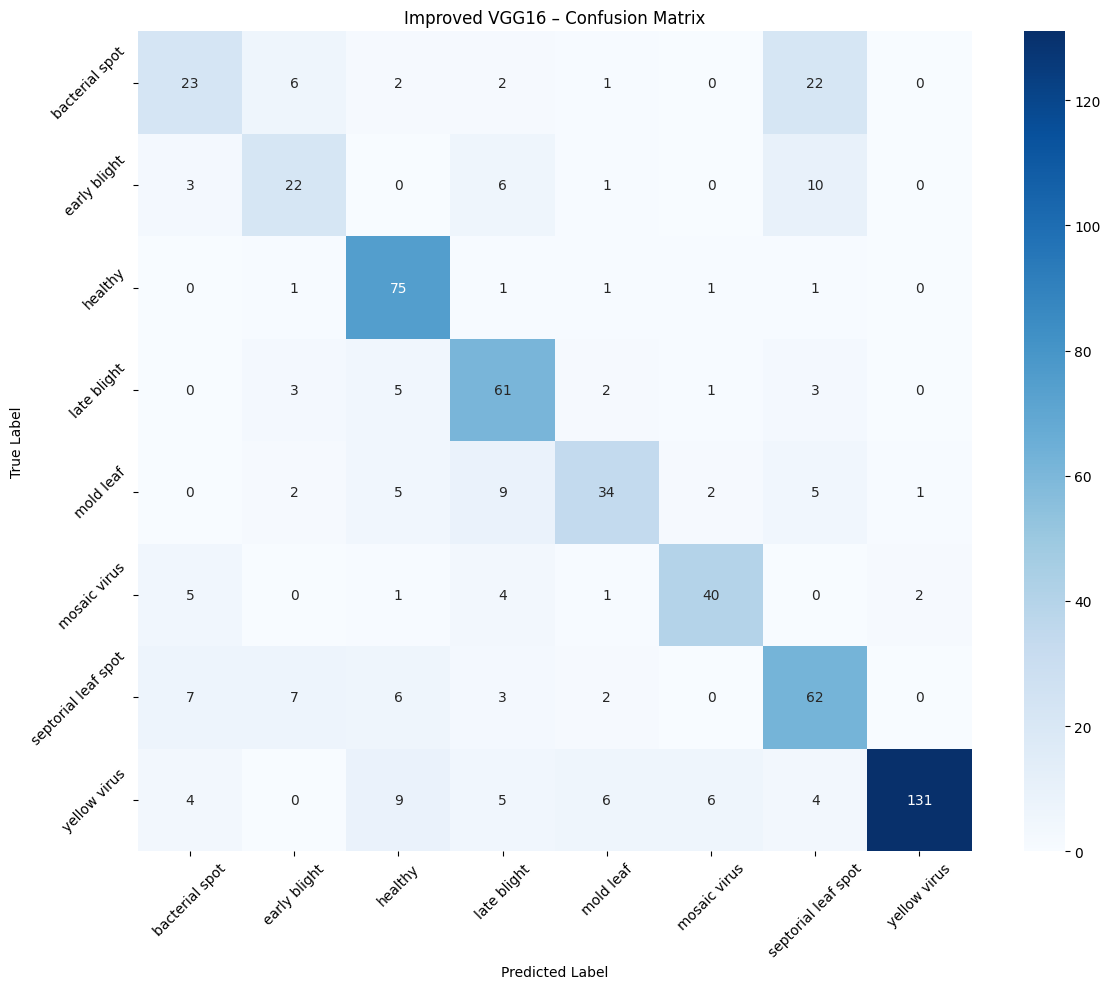

Classification Report:

                     precision    recall  f1-score   support

     bacterial spot       0.55      0.41      0.47        56
       early blight       0.54      0.52      0.53        42
            healthy       0.73      0.94      0.82        80
        late blight       0.67      0.81      0.73        75
          mold leaf       0.71      0.59      0.64        58
       mosaic virus       0.80      0.75      0.78        53
septorial leaf spot       0.58      0.71      0.64        87
       yellow virus       0.98      0.79      0.88       165

           accuracy                           0.73       616
          macro avg       0.69      0.69      0.69       616
       weighted avg       0.74      0.73      0.73       616



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_probs = model.predict(test_generator)
y_pred = np.argmax(y_probs, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title("Improved VGG16 – Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))


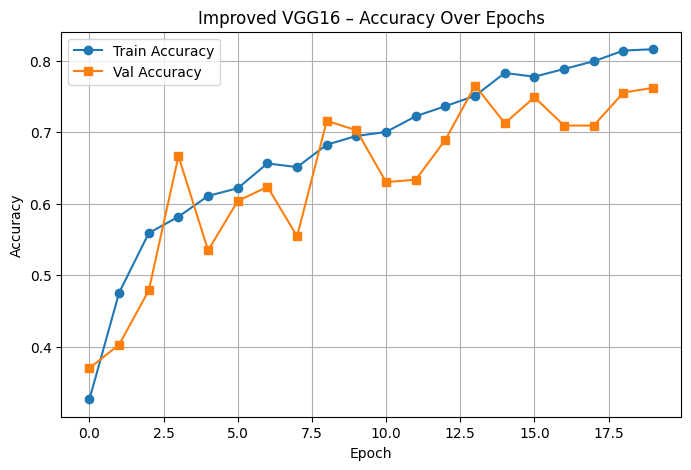

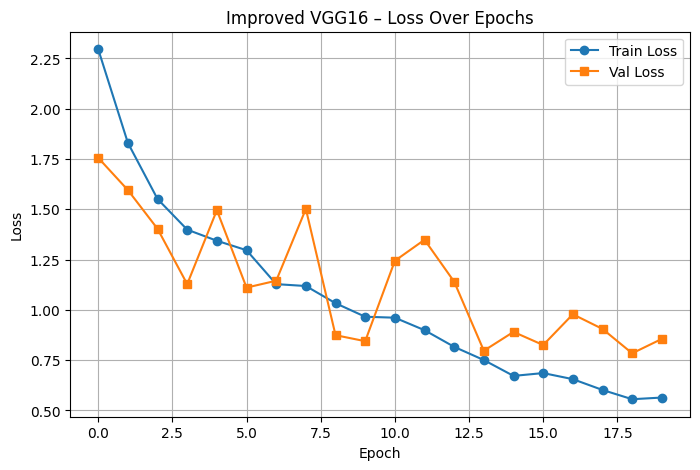

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='s')
plt.title('Improved VGG16 – Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='s')
plt.title('Improved VGG16 – Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
model.save('/content/drive/MyDrive/vgg16_final_model_improved.keras')
print("✅ Final improved VGG16 model saved to Google Drive")


✅ Final improved VGG16 model saved to Google Drive
